In [1]:
from mastodon import Mastodon
from collections import Counter, defaultdict
import csv
from datetime import datetime, timezone
from dateutil.parser import parse
import os
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import requests

from mastodon_access_info import my_access_info

In [2]:
# Authenticate using client credentials
mastodon = Mastodon(
    client_id=my_access_info['client_id'],
    client_secret=my_access_info['client_secret'],
    access_token=my_access_info['access_token'],
    api_base_url='https://mastodon.social'
)

In [3]:
def get_prominent_users(query, limit=80):
    """
    Fetch and analyze user accounts based on a search query and rank them by number of followers.

    Parameters:
    query (str): The search query to find user accounts.
    limit (int): The maximum number of accounts to fetch. Default is 50. Maximum is 80.

    Returns:
    pd.DataFrame: A DataFrame containing the user data, sorted by number of followers in descending order.
    """

    # Search for accounts using a query
    accounts = mastodon.account_search(query, limit=limit)
    
    user_data = []
    
    for account in accounts:
        # Fetch follower count
        follower_count = account['followers_count']
        
        # Append to user data list
        user_data.append({
            'user_id': account['id'],  # Add user ID
            'username': account['username'],
            'display_name': account['display_name'],
            'followers_count': follower_count
        })
    
    # Create a DataFrame for easy analysis
    df = pd.DataFrame(user_data)
    
    # Sort by number of followers
    df_sorted = df.sort_values(by='followers_count', ascending=False)
    
    return df_sorted

In [4]:
def analyze_top_users_posts():
    """
    Analyze the posts of the top 80 Mastodon users by follower count.

    This function fetches recent posts of the top 80 Mastodon users based on their follower count.
    It calculates the post frequency and extracts the engagement times of each user's posts.

    Returns:
    list: A list of dictionaries containing statistics for each user, including username, display name,
          post frequency, and engagement times.
    """
    # Get the top 100 Mastodon users
    top_users = get_prominent_users(query='mastodon', limit=80)  # Adjust the query and limit as needed
    
    user_stats = []
    
    for index, user in top_users.iterrows():
        # Fetch recent posts of the user
        user_posts = mastodon.account_statuses(user['user_id'], limit=100)  # limit catches the number of recent posts of a user
        
        # Calculate post frequency
        post_frequency = len(user_posts) / 100  # Assuming 100 is the limit of recent posts
        
        # Extract engagement times (for simplicity, let's consider posting times)
        engagement_times = [post['created_at'] for post in user_posts]
        
        # Add user statistics to the list
        user_stats.append({
            'username': user['username'],
            'display_name': user['display_name'],
            'post_frequency': post_frequency,
            'engagement_times': engagement_times
        })

    return user_stats

### Identify the TOP 80 Users

Prominence is defined by the number of followers.

In [5]:
prominent_users = get_prominent_users(query='mastodon', limit=80)
prominent_users.head()

,user_id,username,display_name,followers_count
62,109363522574341875,auschwitzmuseum,Auschwitz Memorial,91584
13,84340,Curator,Mastodon•ART 🎨 Curator,59884
55,108201902575564259,SocraticEthics,Ukraine War Bulletins and News,58125
53,109326835262387025,internetarchive,internetarchive,49711
51,109366313013490971,signalapp,Signal,48427


In [6]:
# Calculate median followers count
median_followers = prominent_users['followers_count'].median()

# Create the bar plot with hovertemplate
fig1 = go.Figure([
    go.Bar(
        x=prominent_users['username'],
        y=prominent_users['followers_count'],
        hovertemplate='Username: %{x}<br>Followers Count: %{y}',
        name='Followers Count'
    )
])

# Add a red solid line for the median
fig1.add_hline(y=median_followers, line=dict(color='red', width=1.5, dash='solid'), name='Median Followers')

# Add annotation for median
fig1.add_annotation(
    xref='paper', yref='y',
    x=1, y=median_followers+5000,
    text='Median',
    showarrow=False,
    font=dict(color='red', size=12),
    align='left'
)

# Customize the layout
fig1.update_layout(
    title='Top 80 Mastodon Users by Followers',
    xaxis_title='Username',
    yaxis_title='Number of Followers',
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
    hoverlabel=dict(namelength=0),  # Remove trace name from hover tooltip
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    font=dict(size=12),  # Set font size
    margin=dict(l=50, r=50, t=100, b=50),  # Adjust margins
    plot_bgcolor='white',  # Set background color
)

# Show the plot
fig1.show()



In [7]:
# Calculate median followers count
median_followers = prominent_users['followers_count'].median()

# Create the bar plot with hovertemplate
fig2 = go.Figure([
    go.Bar(
        x=prominent_users['username'],
        y=prominent_users['followers_count'],
        hovertemplate='Username: %{x}<br>Followers Count: %{y}',
        name='Followers Count'
    )
])

# Add a red solid line for the median
fig2.add_hline(y=median_followers, line=dict(color='red', width=1.5, dash='solid'), name='Median Followers')

# Add annotation for median
fig2.add_annotation(
    xref='paper', yref='y',
    x=1, y=median_followers,
    text='Median',
    showarrow=False,
    font=dict(color='red', size=12),
    align='left'
)

# Customize the layout
fig2.update_layout(
    title='Top 80 Mastodon Users by Followers',
    xaxis_title='Username',
    yaxis_title='Number of Followers (log-scaled)',
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
    hoverlabel=dict(namelength=0),  # Remove trace name from hover tooltip
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    font=dict(size=12),  # Set font size
    margin=dict(l=50, r=50, t=100, b=50),  # Adjust margins
    plot_bgcolor='white',  # Set background color
    yaxis=dict(type='log'),  # Set y-axis to log scale
)

# Show the plot
fig2.show()


### Identify post frequency of TOP 80 users (since May 1st 2024)

In [8]:
# Assuming top_users is your DataFrame containing the top users data
user_stats = []

# Specify the start date (May 1, 2024) in UTC timezone
start_date = datetime(2024, 5, 1, tzinfo=timezone.utc)

# Iterate over the top users
for user_id in prominent_users['user_id']:
    # Fetch all posts for the user (no need to specify limit)
    user_posts = mastodon.account_statuses(user_id)
    
    # Filter posts created since May 1, 2024
    posts_since_may_1 = [post for post in user_posts if parse(str(post['created_at'])).replace(tzinfo=timezone.utc) >= start_date]
    
    # Get the count of filtered posts
    num_posts_since_may_1 = len(posts_since_may_1)
    
    # Append user ID and post count since May 1, 2024 to user_stats list
    user_stats.append({'user_id': user_id, 'num_posts_since_may_1': num_posts_since_may_1})

# Convert user_stats list to a DataFrame
user_stats_df = pd.DataFrame(user_stats)

# Merge Data Frames
prominent_users_stats = pd.merge(user_stats_df, prominent_users, on='user_id')

In [9]:
# Sort the DataFrame by the number of posts since May 1, 2024
prominent_users_stats = prominent_users_stats.sort_values(by='num_posts_since_may_1', ascending=False)

# Create a bar plot
fig_nposts = go.Figure(go.Bar(
    x=prominent_users_stats['username'],  # User display names
    y=prominent_users_stats['num_posts_since_may_1'],  # Number of posts since May 1, 2024
#    marker_color='skyblue',  # Color of the bars
))

# Update the layout
fig_nposts.update_layout(
    title='Number of Posts of TOP 80 Users Since May 1, 2024',
    xaxis_title='User',
    yaxis_title='Number of Posts',
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
    hoverlabel=dict(namelength=0),  # Remove trace name from hover tooltip
    font=dict(size=12),  # Set font size
    margin=dict(l=50, r=50, t=100, b=50),  # Adjust margins
    plot_bgcolor='white',  # Set background color
    yaxis=dict(range=[0, 60])  # Set the y-axis range from 0 to 60
)

# Show the plot
fig_nposts.show()

### Identify daily peak interaction times of TOP 80 user

In [10]:
top_users_stats = analyze_top_users_posts()

In [11]:
# Define time intervals (e.g., hourly intervals)
hourly_intervals = defaultdict(int)

# Count engagements within each hourly interval
for user in top_users_stats:  
    for engagement_time in user['engagement_times']:
        # Extract the hour from the engagement time
        hour = engagement_time.hour
        
        # Increment the engagement count for the corresponding hour
        hourly_intervals[hour] += 1

# Create a bar plot for posting frequency over hourly intervals
fig_engagement_hourly = go.Figure(go.Bar(
    x=list(hourly_intervals.keys()),
    y=list(hourly_intervals.values()),
    hovertemplate='Hour: %{x}<br>Posting Count: %{y}',  # Customize hover information
))

fig_engagement_hourly.update_layout(
    title='Posting Frequency of Top 80 Users by Daily Hours',
    xaxis_title='Hour of Day',
    yaxis_title='Posting Count',
    hoverlabel=dict(namelength=0),  # Remove trace name from hover tooltip
    font=dict(size=12),  # Set font size
    margin=dict(l=50, r=50, t=100, b=50),  # Adjust margins
    plot_bgcolor='white',  # Set background color
)

fig_engagement_hourly.show()

### **What are the TOP 10 hashtags?**

That is those used most frequently within the last week.

In [12]:
# Function to get trending hashtags
def get_trending_hashtags():
    url = f'{mastodon.api_base_url}/api/v1/trends/tags'
    headers = {
        'Authorization': f'Bearer {mastodon.access_token}'
    }
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        trending_tags = response.json()
        return trending_tags
    else:
        print(f'Error: {response.status_code}')
        print(response.json())
        return []

# Fetch and print the trending hashtags
trending_hashtags = get_trending_hashtags()
for tag in trending_hashtags:
    print(f"{tag['name']}")
#    print(f"Uses: {tag['history'][0]['uses']}")
#    print("-" * 40)


caturday
gameshowquestionsforfruit
TrumpGuiltyASongOrPoem
FensterFreitag
saturday
みんなのメカクレが見たい
WindowFriday
6月になったし自分のアイコン自慢しようね
pridemonth
米に合うもの選手権


In [13]:
# Extract hashtag names and their interaction counts (e.g., number of uses)
hashtag_data = [
    (tag['name'], int(tag['history'][0]['uses']))
    for tag in trending_hashtags if 'history' in tag and len(tag['history']) > 0
]

# Sort the hashtags by interaction counts
hashtag_data_sorted = sorted(hashtag_data, key=lambda x: x[1], reverse=True)

# Separate the sorted data into names and counts
hashtag_names_sorted = [item[0] for item in hashtag_data_sorted]
interaction_counts_sorted = [item[1] for item in hashtag_data_sorted]

# Create a bar plot with a color scheme
fig_hashtags = go.Figure(go.Bar(
    x=hashtag_names_sorted,
    y=interaction_counts_sorted,
    hovertemplate='Hashtag: %{x}<br>Interactions: %{y}',
))

# Update the layout
fig_hashtags.update_layout(
    title='Trending Hashtags and Their Interactions',
    xaxis_title='Hashtag',
    yaxis_title='Number of Interactions',
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
    hoverlabel=dict(namelength=0),  # Remove trace name from hover tooltip
    font=dict(size=12),  # Set font size
    margin=dict(l=50, r=50, t=100, b=50),  # Adjust margins
    plot_bgcolor='white',  # Set background color
)

# Show the plot
fig_hashtags.show()

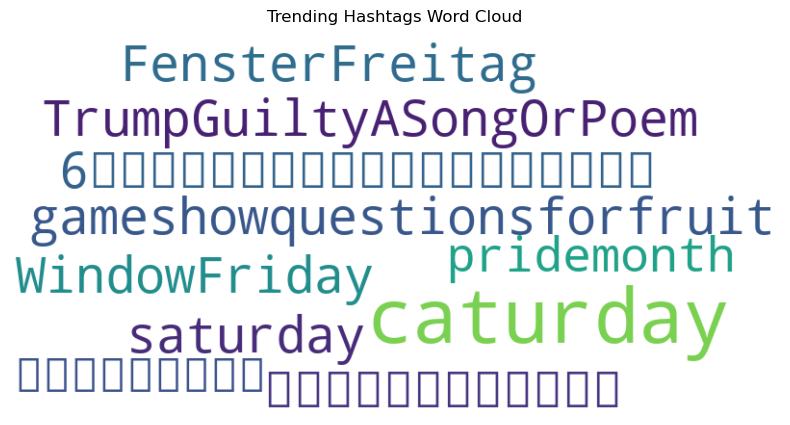

In [14]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Extract hashtag names and interaction counts
hashtag_names = [tag['name'] for tag in trending_hashtags]
interaction_counts = [int(tag['history'][0]['uses']) for tag in trending_hashtags]

# Combine hashtag names and interaction counts into a single string
text = ' '.join([f'{name}:{count}' for name, count in zip(hashtag_names, interaction_counts)])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axis
plt.title('Trending Hashtags Word Cloud')  # Set title
plt.show()

Trump and work related stuff seem to make the race! (The code was lust run on June 1st 2024. So your results from now on might differ.)

### What are the TOP 40 Statuses

These are the most interacted statuses.

In [15]:
# Function to get trending statuses
def get_trending_statuses():
    url = f'{mastodon.api_base_url}/api/v1/trends/statuses'
    headers = {
        'Authorization': f'Bearer {mastodon.access_token}'
    }
    params = {
        'limit': 40  # Specify the count of statuses to retrieve
    }
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        trending_statuses = response.json()
        return trending_statuses
    else:
        print(f'Error: {response.status_code}')
        print(response.json())
        return []

# Fetch and print the trending statuses (top 40)
trending_statuses = get_trending_statuses()

Based on what we have seen from the TOP 10 hashtags of the last week do we see also that the currently most trending statuses are about work and Trump?

In [16]:
# Function to count the occurrences of each topic in the filtered statuses
def count_topic_occurrences(filtered_statuses, topic_keywords):
    topic_counts = {topic: 0 for topic in topic_keywords.keys()}
    for status in filtered_statuses:
        content = status['content'].lower()
        for topic, keywords in topic_keywords.items():
            if any(keyword in content for keyword in keywords):
                topic_counts[topic] += 1
    return topic_counts

# Define topics and their associated keywords
TOPIC_KEYWORDS = {
    'Trump': ['trump', 'president', 'new york', 'justice', 'trial', 'guilty', 'maga', 'schuldig'],
    'Work': ['work', 'friday', 'holiday', 'weekend', 'Freitag', 'Saturday', 'Sunday', 'Samstag', 'Sonntag', 'Party'],
    
}

# Fetch and print the trending statuses
trending_statuses = get_trending_statuses()

# Count occurrences of each topic in the filtered statuses
topic_counts = count_topic_occurrences(trending_statuses, TOPIC_KEYWORDS)

# Print the counts for each topic
print("Topic Counts:")
for topic, count in topic_counts.items():
    print(f"{topic.capitalize()}: {count}")


Topic Counts:
Trump: 4
Work: 5


In [17]:
# Extract topics and counts from the topic_counts dictionary
topic_names = list(topic_counts.keys())
topic_counts_values = list(topic_counts.values())

# Define the data for the horizontal bar chart
data = [
    go.Bar(
        y=topic_names,  # Use topic names as y-axis values
        x=topic_counts_values,  # Use topic counts as x-axis values
        orientation='h',  # Set orientation to horizontal
        text=topic_counts_values,  # Add text labels for each bar
        textposition='inside',  # Set text position inside the bars
        textfont=dict(color='white'),  # Set text color to white
    )
]

# Define the layout for the horizontal bar chart
layout = go.Layout(
    title='Top Trending Status Topics (from TOP 40 Statuses)',
    xaxis=dict(title='Count', automargin=True),  # Automatically adjust margins for x-axis labels
    yaxis=dict(title='Topics', automargin=True),  # Automatically adjust margins for y-axis labels
    font=dict(size=12),  # Set font size
    margin=dict(l=50, r=50, t=100, b=50),  # Adjust margins
    plot_bgcolor='white',  # Set background color
)

# Create the figure for the horizontal bar chart
fig_trend_topics = go.Figure(data=data, layout=layout)

# Display the horizontal bar chart
fig_trend_topics.show()


Again, Trump and work related topics seem to make the race.

Now save all the figures as png-files.

In [18]:
if not os.path.exists("pics"):
    os.makedirs("pics")

# Specify the file path for saving the images in the "pics" subfolder
file_path_fig1 = os.path.join("pics", "top80.png")
file_path_fig2 = os.path.join("pics", "top80_log.png")
file_path_fig_nposts = os.path.join("pics", "n_posts.png")
file_path_fig_engagement_hourly = os.path.join("pics", "engagement_hourly.png")
file_path_fig_trend_topics = os.path.join("pics", "trending_topics.png")
file_path_fig_hashtags = os.path.join("pics", "trending_hashtags.png")
file_path_plt = os.path.join("pics", "wordcloud.png")


# Save the images with the specified file paths
pio.write_image(fig1, file_path_fig1, scale=2)
pio.write_image(fig2, file_path_fig2, scale=2)
pio.write_image(fig_engagement_hourly, file_path_fig_engagement_hourly, scale=2)
pio.write_image(fig_trend_topics, file_path_fig_trend_topics, scale=2)
pio.write_image(fig_nposts, file_path_fig_nposts, scale=2)
pio.write_image(fig_hashtags, file_path_fig_hashtags, scale=2)
plt.savefig(file_path_plt, dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

...and save the TOP 80 users and the TOP 10 trending hashtags in seperate csv-files.

In [19]:
if not os.path.exists("csv_files"):
    os.makedirs("csv_files")

# Function to save trending hashtags as a CSV file
def save_trending_hashtags_csv(trending_hashtags, filename):
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['name', 'uses']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for tag in trending_hashtags:
            writer.writerow({'name': tag['name'], 'uses': tag['history'][0]['uses']})

# Fetch trending hashtags
trending_hashtags = get_trending_hashtags()

# Specify the filename
filename = 'csv_files/top10_hashtags.csv'

# Save trending hashtags as a CSV file
save_trending_hashtags_csv(trending_hashtags, filename)

# Save TOP80 users
prominent_users.to_csv('csv_files/top80_users.csv', index=False)

Done.